In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline
import itertools

import ase
import matplotlib.pyplot as plt
import numpy as np
from abtem.inelastic.plasmons import MonteCarloPlasmons

import abtem

abtem.config.set({"device": "gpu"})

# Plasmons

In this tutorial we reproduce the paper by BG Mendis that first introduced the Monte Carlo method for simulating plasmons{cite}`mendis_plasmons`. See the paper for a detailed description of the method, and see our citation guide, if you use this method in your research.

The method is demonstrated in two different modes:
* Energy filtered CBED: Experimentally equivalent to setting the energy of an energy-filter to a specific plasmon peak while collecting a CBED pattern.
* STEM with plasmon loss: Experimentally equivalent to non-filtered STEM, where the scattering of an appropriately high number of excitations are averaged.

## Energy-filtered CBED

We start by doing the energy-filtered CBED calculation. We create a sample of silicon in the $\{110\}$ direction, we repeat it in $z$ up to the desired thickness of $1600 \ \mathrm{Å}$ and in $xy$ to accomodate the probe size and to simulate a thermal ensemble.

We create a typical potential with frozen phonons with an rms displacement of the silicon atoms of $0.078 \ \mathrm{Å}$. 

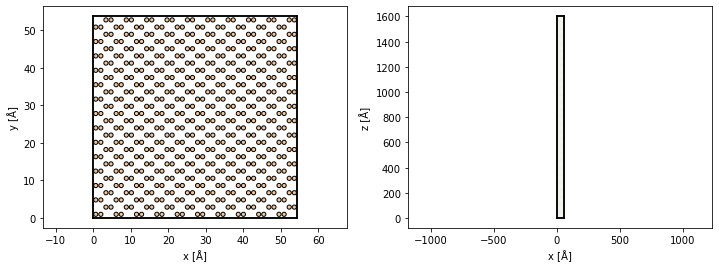

In [2]:
atoms = ase.build.bulk("Si", cubic=True)

atoms = ase.build.surface(atoms, indices=(0, 1, 1), layers=3, periodic=True)

atoms = abtem.orthogonalize_cell(atoms)

atoms *= (10, 7, 139)

atoms.center()

frozen_phonons = abtem.FrozenPhonons(atoms, sigmas=0.078, num_configs=50)

potential = abtem.Potential(frozen_phonons, slice_thickness=1.9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, plane="xy", scale=0.5, ax=ax1)
abtem.show_atoms(atoms, plane="xz", scale=0.5, ax=ax2, linewidth=0.0);

We create a probe with an energy of $200 \ \mathrm{keV}$, a convergence semiangle of $3.9 \ \mathrm{mrad}$, a spherical aberration of $1 \ \mathrm{mm}$ and defocus of $-600 \ \mathrm{Å}$. We create a pixelated detector with a maximum angle to limit the disk of our output.

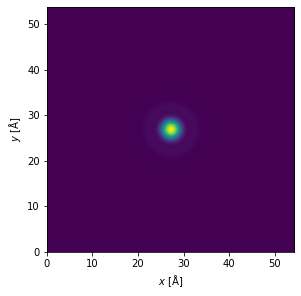

In [3]:
Cs = 1e-3 * 1e10
defocus = -600

probe = abtem.Probe(
    energy=200e3,
    gpts=1024,
    semiangle_cutoff=3.9,
    Cs=Cs,
    defocus=defocus,
)

probe.grid.match(potential)

detectors = abtem.PixelatedDetector(max_angle=120)

probe.show()

The main interface for simulating plasmons is the `MonteCarloPlasmons` class. We set the plasmon mean free path to $\lambda_p = 1050 \ \mathrm{Å}$, the critical angle is set to $\theta_c = 27.6 \ \mathrm{mrad}$ and the plasmon excitation energy is set to $E_p = 27$, thus the characteristic angle at $200 \ \mathrm{keV}$ is

$$
    \theta_E \approx \frac{2 E_p}{E_0} \approx 0.004 \ \mathrm{mrad} \quad .
$$

We want simulations of zero loss, single, double and triple excitations, hence, we will obtain the scattering signal equivalent to setting the energy-filter to energies of $0 \ \mathrm{eV}$ (normal multislice), $17 \ \mathrm{eV}$, $34 \ \mathrm{eV}$ and $51 \ \mathrm{eV}$. We perform the Monte Carlo integration over $50$ random samples for each excitation (i.e. not including the zero loss) and set a seed to make the simulation reproducible.

Note that for each of the plasmon samples we also have $50$ phonon configurations, thus a total of $3 \times 50 \times 50 = 7500$ runs of the multislice algorithm are required.

In [4]:
plasmons = MonteCarloPlasmons(
    mean_free_path=1050,
    excitation_energy=17,
    critical_angle=27.6,
    num_samples=50,
    num_excitations=[0, 1, 2, 3],
    seed=0,
)

We randomly draw the depths of the inelastic scattering events as well as the radial and azimuthal scattering angles using the `.draw_events` method. 

In [5]:
events = plasmons.draw_events(probe, potential)

Denoting a uniform random number over the range $[0,1]$ as $\mathrm{RND}$, the scattering lengths $s$ are obtained from a Poisson distribution

$$
    s = \lambda_p \log \mathrm{RNG} \quad .
$$

We show cumulative distribution plots for the depths of the first, second and third plasmon scattering events. All scattering events must happen before the exit plane; hence given a specified sample depth the first scattering event of a triple plasmon excitation generally occurs closer to the entrance, whereas the third scattering event of a triple plasmon excitation generally must happen deep in the sample.

[<AxesSubplot: > <AxesSubplot: > <AxesSubplot: >]


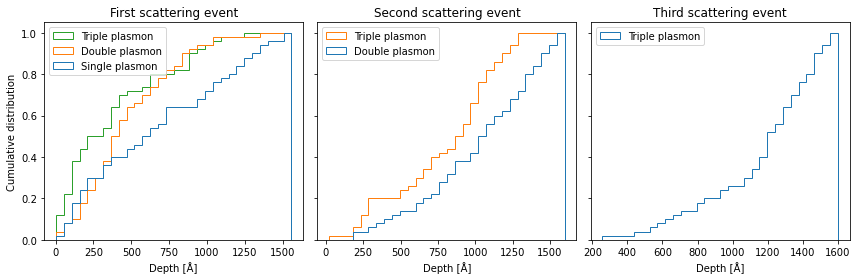

In [6]:
ax = events.show_cumulative_scattering_events(num_excitations=[1, 2, 3], bins=30)

figure = plt.gcf()
figure.set_size_inches(12, 4)
plt.tight_layout()

The radial scattering angles are distributed according to

$$
    \theta = (\theta_c^2 + \theta_E^2)^{\mathrm{RND}} - \theta_E^2 \quad ,
$$

and the azimuthal angles are unformly distributed on the circle

$$
    \phi = 2 \pi \mathrm{RND} \quad .
$$

We show the distribution of radial scattering angles below. The majority of scattering events occur at angles $<2 \ \mathrm{mrad}$ due to the small characteristic angle, although scattering that approach the critical angle is also possible.

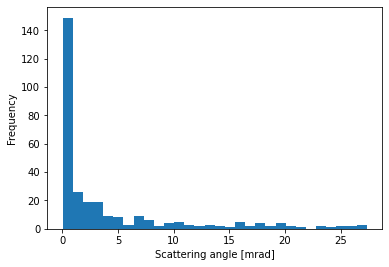

In [7]:
events.show_scattering_angle_distribution(bins=30)

The likelyhood of different numbers of excitations, $N$, depends on the mean free path and the depth, $t$, of the sample. Thus each number of excitations is weighted according to

$$
    w_N = \frac{1}{N!} \left(\frac{t}{\lambda_p}\right)^N \exp\left(-\frac{t}{\lambda_p}\right) \quad .
$$

In this case, a single plasmon excitations is more likely than both zero loss and two or more excitations.

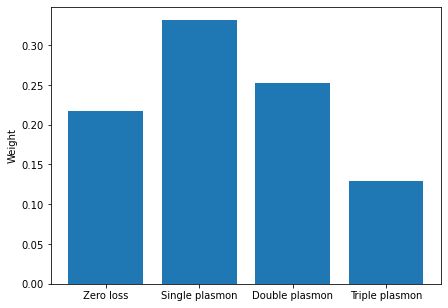

In [8]:
events.show_weights()

We set up the multislice simulations with plasmons.

In [9]:
from abtem.inelastic.plasmons import reduce_plasmon_axes

# This interface will be improved in our final version

plasmon_probes = probe.copy().insert_transform(events)

measurements = plasmon_probes.multislice(potential, detectors=detectors)

measurements = reduce_plasmon_axes(measurements)

We call `.to_zarr` to run the simulation and write the result to disk. This may be expensive depending on your hardware, the calculation took about 45 min on an Nvidia 2080Ti GPU.

In [10]:
#measurements.to_zarr("energy_filtered_cbed.zarr")

The result is read back in.

In [11]:
measurements = abtem.from_zarr("energy_filtered_cbed.zarr").compute()

[########################################] | 100% Completed | 112.17 ms


We show the diffraction patterns for each number of excitation on individually normalized colorscales. We see that the contrast of features are reduced in the energy-filtered patterns, especially within the bright-field disk.

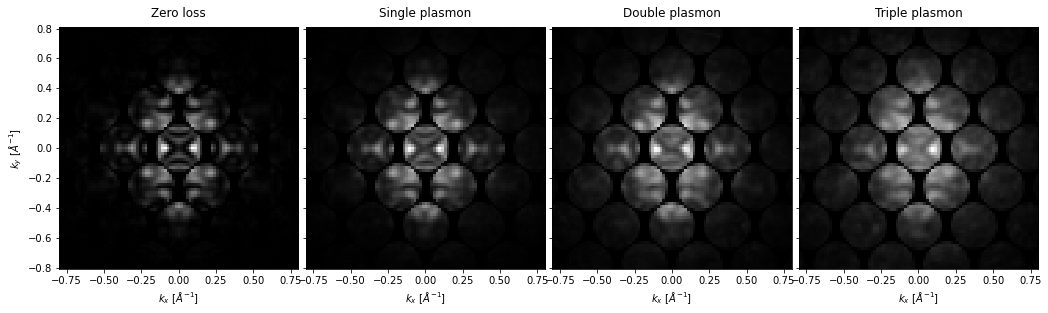

In [12]:
measurements.crop(20).show(
    explode=True,
    figsize=(16, 4),
    cmap="gray",  # cbar=True,
);

To make the comparison more quantitative we extract horizontal lineprofiles averaged over the 002 Kikuchi line. The area is shown as a red box shown in the next output cell.

In [26]:
lineprofile = measurements.interpolate_line_at_position(
    center=(0.0, 2), extent=1.4, angle=0.0, width=0.5, endpoint=True
)

We show the diffraction patterns up to a larger maximum angle on a power scale.

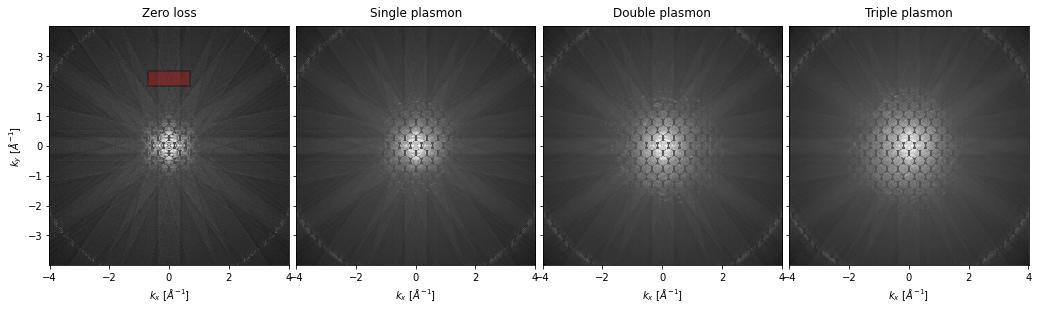

In [27]:
visualization = measurements.crop(100).show(
    explode=True, figsize=(16, 4), cmap="gray", power=0.2
)

visualization.add_area_indicator(
    lineprofile, edgecolor="k", linewidth=2, facecolor="red", alpha=0.25, panel="first"
)

Finally, we show the line profiles, normalized for direct visual comparison. We see that the contrast of the Kikuchi line is reduced in the energy-filtered lineprofiles.

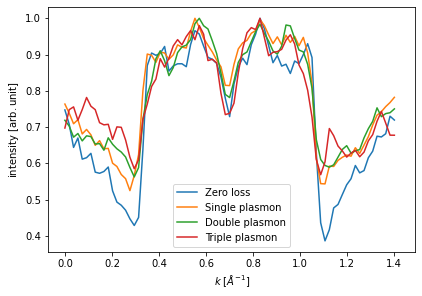

In [28]:
lineprofile.normalize_ensemble(scale="max", shift="none").show()

## STEM with plasmon loss

Next, we do a STEM simulation with a much thinner sample.

We create a sample of silicon in the $\{110\}$ direction and repeat it in $z$ up to the desired thickness of $100 \ \mathrm{Å}$. We create a standard potential with frozen phonons with an rms displacement of the silicon atoms of $0.078 \ \mathrm{Å}$. 

In [48]:
atoms = ase.build.bulk("Si", cubic=True)

atoms = ase.build.surface(atoms, indices=(0, 1, 1), layers=3, periodic=True)

atoms = abtem.orthogonalize_cell(atoms)

repetitions = (5, 4, 9)
atoms *= repetitions
atoms.center()

frozen_phonons = abtem.FrozenPhonons(atoms, sigmas=0.078, num_configs=50)

potential = abtem.Potential(
    frozen_phonons, slice_thickness=1.9, parametrization="lobato"
)

We create a line scan across one of the silicon dumbells, shown as a red line in the left panel below.

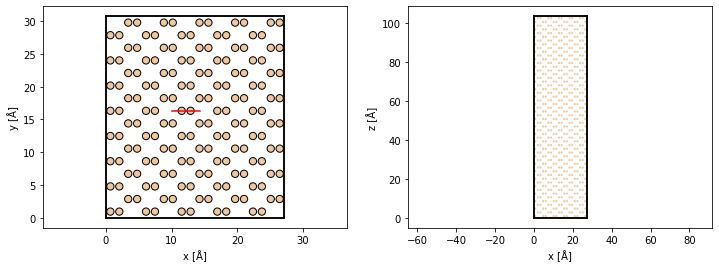

In [49]:
scan = abtem.LineScan(start=atoms[2160], end=atoms[2161], sampling=0.1)

scan.add_margin(1.4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, plane="xy", scale=0.5, ax=ax1)
abtem.show_atoms(atoms, plane="xz", scale=0.5, ax=ax2, linewidth=0.0)

scan.add_to_axes(ax1, color="r")

We create an aberrations-free probe with an energy of $200 \ \mathrm{keV}$ and a convergence semiangle of $20 \ \mathrm{mrad}$.

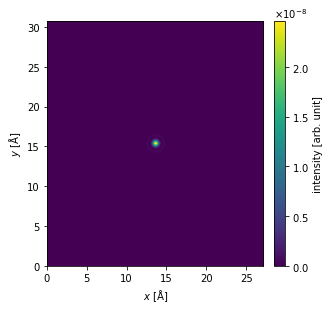

In [50]:
probe = abtem.Probe(
    energy=200e3,
    gpts=512,
    semiangle_cutoff=20,
)

probe.grid.match(potential)

detectors = abtem.FlexibleAnnularDetector()

probe.show(cbar=True)

We create our `MonteCarloPlasmons` class identical to earlier, however, we only include single excitations as higher excitations is unprobable for samples of this lower thickness.

In [55]:
plasmons = MonteCarloPlasmons(
    mean_free_path=1050,
    excitation_energy=17,
    critical_angle=27.6,
    num_samples=50,
    num_excitations=1,
    seed=15,
)

events = plasmons.draw_events(probe, potential)

We show the depth of the scattering event the distribution of radial scattering angles, however, these plots only differ from the above due to using randomness.

[<AxesSubplot: >]


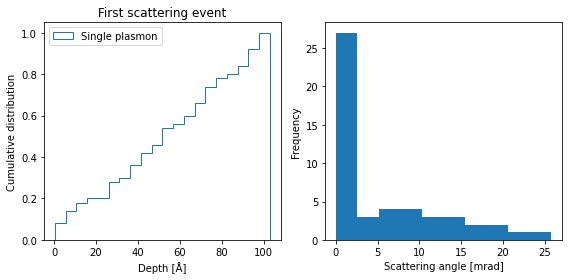

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

events.show_cumulative_scattering_events(ax=ax1)
events.show_scattering_angle_distribution(ax=ax2)
plt.tight_layout()

We run the multislice calculations for each probe positions with the plasmon loss.

In [57]:
from abtem.inelastic.plasmons import reduce_plasmon_axes

# This interface will be improved in our final version

plasmon_probes = probe.copy().insert_transform(events)

line_profiles = plasmon_probes.scan(potential, scan=scan, detectors=detectors)

line_profiles = reduce_plasmon_axes(line_profiles)

We run the simulations.

In [58]:
line_profiles.compute()

[########################################] | 100% Completed | 12m 50s


We integrate the output between $80$ and $200 \ \mathrm{mrad}$. The result show that with plasmons 

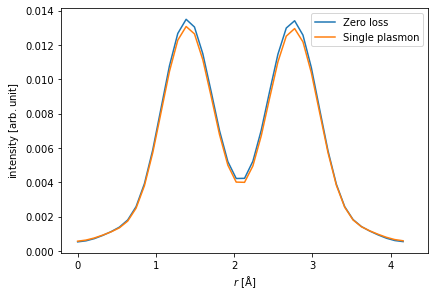

In [64]:
line_profiles.integrate_radial(inner=80, outer=130).show()